In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV # for hyperparameter tuning
import optuna as optuna # for hyperparameter tuning

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import shap # for model interpretability

import sys
sys.path.append('../src')
from EvaluationFunction import evaluate_model
from ValidationCross import cross_val_results

In [2]:
df = pd.read_csv("../data/preprocessed_data.csv")

In [20]:
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [19]:
# Diviser les données
X_train, X_test_shap, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [4]:
# Charger le fichier
pipeline = joblib.load('../models/best_model.pkl')

# Extraire le modèle XGBoost final
xgb_final = pipeline.named_steps['classifier']

# Extraire le préprocesseur
preprocessor = pipeline.named_steps['preprocessor']

# Extraire les noms des colonnes après transformation
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

---
Importance des features - XGBoost
---

C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_15676\1981130254.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')


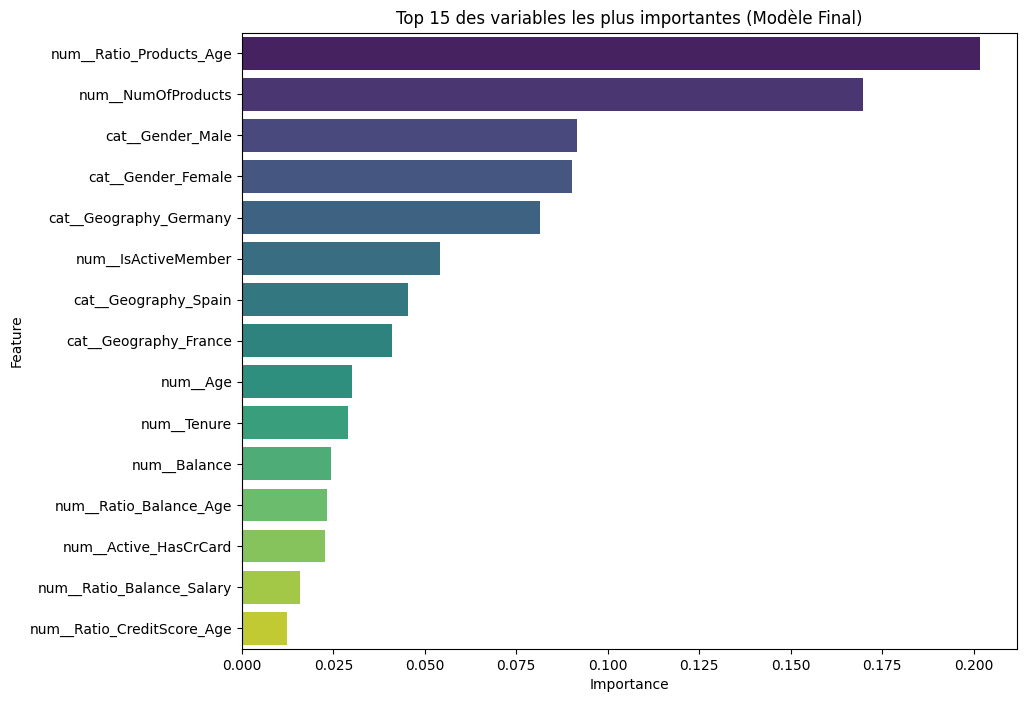

In [5]:
# Récupérer les importances
importances = xgb_final.feature_importances_

# Créer un DataFrame pour faciliter l'affichage
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Afficher les 15 plus importantes
plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(15), x='Importance', y='Feature', palette='viridis')
plt.title('Top 15 des variables les plus importantes (Modèle Final)')
plt.show()

---
XAI SHAP
---

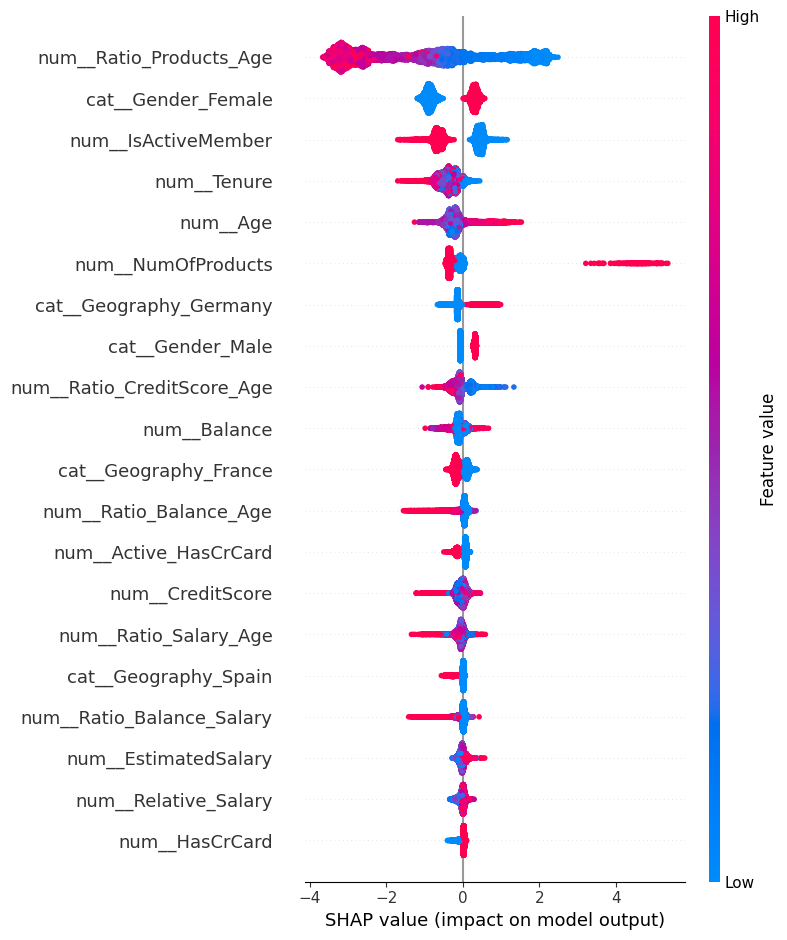

In [21]:
# Prétraiter les données d'entraînement pour SHAP
X_train_preprocessed = preprocessor.transform(X_train)
    
# Conversion en DataFrame pour SHAP
X_train_preprocessed_df = pd.DataFrame(
    X_train_preprocessed,
    columns=feature_names,
    index=X_train.index
)

# Création de l'explainer SHAP
explainer = shap.TreeExplainer(xgb_final.get_booster())

# Calcul des valeurs SHAP
shap_values = explainer(X_train_preprocessed_df)

# SHAP Summary Plot
shap.summary_plot(
    shap_values.values,
    X_train_preprocessed_df,
    feature_names=feature_names
)

---
Analysis XAI
---


Cette section compare deux approches d'explicabilité pour notre modèle XGBoost : 
* L'**Importance Native** (basée sur le gain) 
* **Valeurs SHAP** (basées sur la théorie des jeux).

---

### 1. Comparaison des Méthodologies

| Caractéristique | Importance XGBoost (Gain) | Valeurs SHAP (Summary Plot) |
| :--- | :--- | :--- |
| **Perspective** | Globale : Quelle variable aide le plus à réduire l'erreur ? | Globale & Locale : Comment chaque valeur influence la prédiction ? |
| **Direction** | Uniquement l'amplitude (toujours positif). | Indique la direction (positif/négatif) de l'impact. |
| **Nuance** | Simple et rapide, mais peut être biaisée. | Très précis, capture les interactions complexes. |

---

### 2. Analyse des Résultats du Churn

En observant les deux graphiques, nous pouvons tirer les enseignements suivants :

#### A. Les Drivers Majeurs de Churn
* **`num__Ratio_Products_Age`** : C'est la variable dominante dans les deux méthodes. Le SHAP plot révèle que des valeurs **faibles** (en bleu) augmentent drastiquement la probabilité de churn (SHAP value positive).
* **`num__NumOfProducts`** : Très importante pour XGBoost. Le SHAP plot montre un comportement non-linéaire intéressant : des valeurs très élevées (rouge) poussent fortement vers le churn.
* **`num__IsActiveMember`** : Un indicateur clé. Être un membre non-actif (bleu) augmente significativement le risque de départ.

#### B. Profils à Risque (Insights SHAP)
Le graphique SHAP nous permet de dresser un portrait-robot du client susceptible de partir :
* **Géographie** : Les clients en **Allemagne** (`cat__Geography_Germany` en rouge) ont une tendance au churn plus élevée que les autres.
* **Âge** : Les clients plus **âgés** (en rouge) ont un impact positif sur la SHAP value, indiquant un risque de churn plus élevé.
* **Genre** : Les femmes (`cat__Gender_Female` en rouge) semblent présenter un risque légèrement plus élevé dans ce dataset.

---

### 3. Conclusion sur l'Explicabilité

L'analyse combinée nous permet de conclure que :

1.  **Cohérence** : Les deux méthodes s'accordent sur les variables de tête (`Ratio_Products_Age`, `NumOfProducts`, `IsActiveMember`). Cela renforce notre confiance dans la solidité du modèle.
2.  **Actionnabilité** : L'importance XGBoost nous dit **quoi** regarder, mais SHAP nous dit **comment** agir. Par exemple, savoir que l'inactivité et la localisation en Allemagne sont des facteurs aggravants permet à la banque de créer des campagnes de rétention ciblées.

**Recommandation métier :** Focaliser les efforts de rétention sur les clients possédant peu de produits par rapport à leur ancienneté et les clients inactifs de la zone Allemagne.